# Neural Style Transfer

This application of style transfer does not require a training set at all, but instead we transfer the style of one single image onto another.

In [1]:
import pandas as pd
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import os.path
from os import path

## Loading the paths and showing Base Image and Style Image

In [3]:
### creating a folder for the combined images

combined_folder_name = 'Alex_2_Van_Gogh' 
dir = os.path.join("images","combined_images", combined_folder_name)
if not os.path.exists(dir):
    os.mkdir(dir)

In [4]:
ContentPath = 'images/base_images/'
StylePath = 'images/style_images/'
CombinedPath = dir

In [5]:
base_image_path = ContentPath+'base_image.jpg'
style_image_path = StylePath+'van_gogh.jpg'

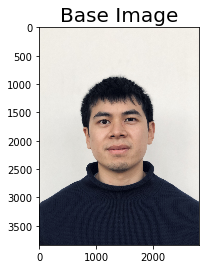

In [6]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)

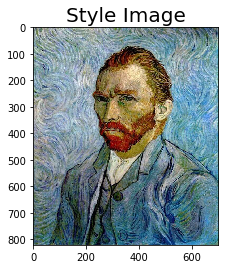

In [7]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(style_image_path)
plt.imshow(img1)

In [8]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [9]:
# this function will open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [10]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

### Placeholders for our generated image

Think of Variable in tensorflow as a normal variables which we use in programming languages. We initialize variables, we can modify it later as well. Whereas placeholder doesn’t require initial value. Placeholder simply allocates block of memory for future use. Later, we can use feed_dict to feed the data into placeholder. By default, placeholder has an unconstrained shape, which allows you to feed tensors of different shapes in a session.

In [11]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [12]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

## Loading the pre-trained VGG19 model

In [13]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19

model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights='imagenet')

Athough Vgg19 is basically used for Classification purpose, but here our objective is not to classify rather our objective is to transform a image, so we do not need all the layers of vgg19, we have specially excluded those layers which are used for classification.

In [14]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Loss functions

There are 3 loss functions to minimize here

### The content Loss

This is designed to make sure the combined image contains the content as the base image. The content loss measures how different two images are in terms of the subject matter and overall placement of their content. We don’t really want the content loss to care about the values of individual pixels; we’d rather that it scores images based on the presence and approximate position of higher-level features such as buildings, sky, or river.

In [16]:
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

### The Style Loss

the "style loss" is designed to maintain the style of the style image in the combined image. It is based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image.

Even though their content may be very different, the Gram matrix—a measure of correlation between all pairs of features in the layer—is similar.

In [17]:
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))
    



### total variance loss

Here we want the combined image to appear smooth rather than pixelated and minimize the loss via gradient descent. This is simply a measure of noise in the combined image.

To judge how noisy an image is, we can shift it one pixel to the right and calculate the sum of the squared difference between the translated and original images. For balance, we can also do the same procedure but shift the image one pixel down. The sum of these two terms is the total variance loss.

In [18]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### Adding all the losses together

In [19]:
content_weight=0.025 
style_weight=1.0

# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * get_content_loss(base_image_features,combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = get_style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

Here we extract the style image features and combined image features from the input tensor that has been fed through the VGG19 network. The style loss is scaled by a weighting parameter and the number of layers that is calculated over.

# remove this is the code doesn't work for some reason

In [20]:
content_weight=0.5 
style_weight=10.0
total_variation_weight=10.0

# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * get_content_loss(base_image_features,combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = get_style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
    
loss = loss + total_variation_weight * total_variation_loss(combination_image)

### Calculation of gradient with respect to loss..

In [21]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/AddN_16:0' shape=(1, 400, 293, 3) dtype=float32>]

In [22]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [23]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [24]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

### Building the Evaluator

this Evaluator class makes it possible to compute loss and gradients in one pass while retrieving them via two separate functions, "loss" and "grads". This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

This will calculate the overall loss, and gradients of the loss with respect to the input image.

In [25]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

This deprocess_image function is used return the original format of the Final image  after transformation which could be easily read and displayed by Matplotlib.

In [26]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

The process is initialized with the base image as the starting combined image. 

Then at each iteration we pass the current combined image (flattened) into a optimization function, fmin_l_bfgs_b from the scipy.optimize package, that performs one gradient descent step according to the L-BFGS-B algorithm

In [27]:
import time

evaluator = Evaluator()

iterations= 2

#storing best results here
best_loss, best_img = float('inf'), None

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    
    # saving results every 5 interations
    if i % 5 == 0:
        imgx = deprocess_image(x_opt.copy())
        plt.imsave(CombinedPath+'combined_result_%d.png' % i, imgx)
    
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()
        
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 5.7618603e+21
Iteration 0 completed in 38s
Start of iteration 1
Current loss value: 2.7966853e+21
Iteration 1 completed in 37s



**The Final Image**

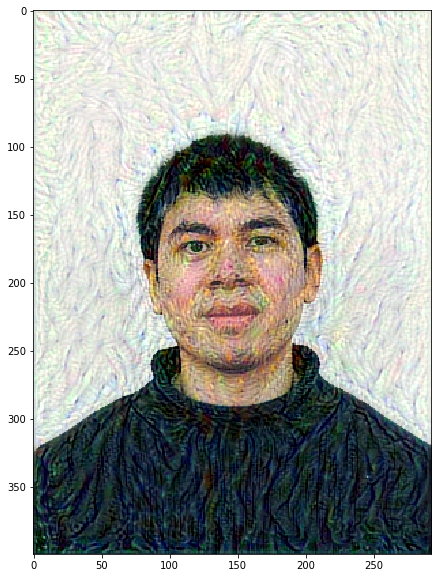

In [28]:
imgx = deprocess_image(best_img.copy())
plt.figure(figsize=(10,10))
plt.imshow(imgx)
#plt.imsave(CombinedPath+'best_result.png',imgx)

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)

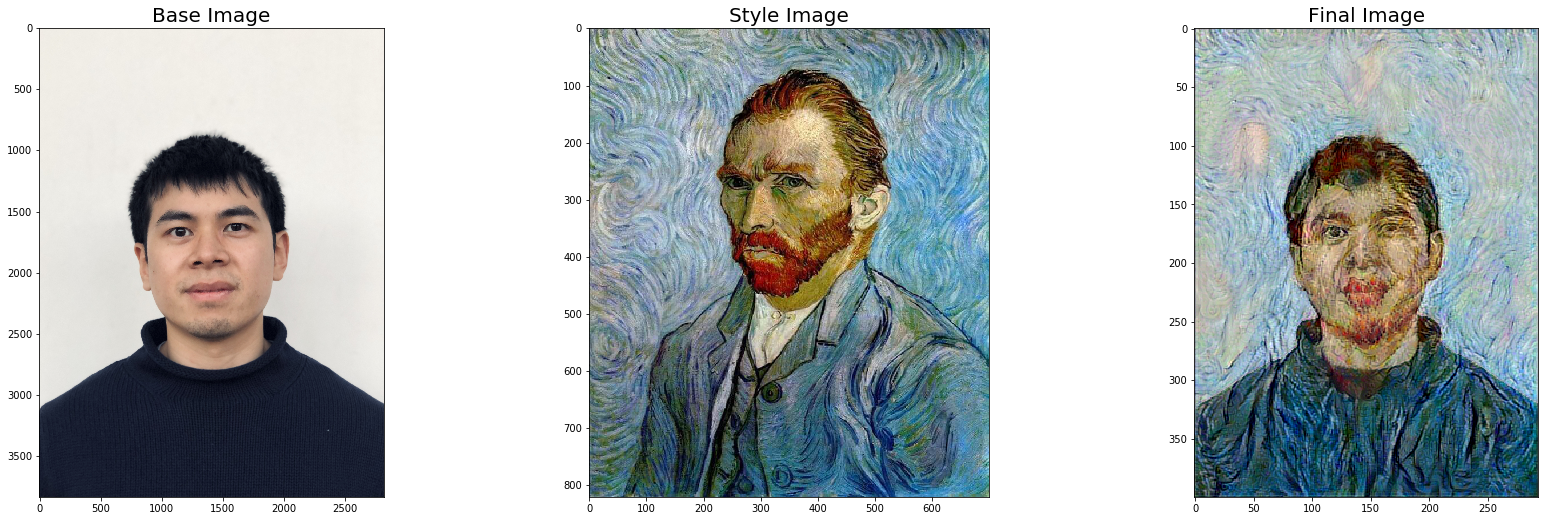

In [23]:
best_image_path = 'images/combined_images/combined_result_95.png'
#img1 = load_img(best_image_path)

plt.figure(figsize=(50,50))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(img1)

plt.savefig('images/test.png')